In [1]:
cd ..

/home/araxal/coursework


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from utils.genre_classification import plot_confusion_matrix
from utils.genre_classification import evaluate, executor, random_features_slicer
from utils.decade_classification import feature_preparator

In [3]:
def transformer(x):
    x = random_features_slicer(x)
    return permute_channels(x)

def permute_channels(x: np.ndarray):
    # channel time, mfcc
    return x.reshape((256, 3, 24)).transpose((1, 0, 2))

In [4]:
BATCH_SIZE = 8
NUM_CLASSES = 4
DEVICE = torch.device('cuda')

In [5]:
%%time
train_data_loader, val_data_loader, test_data_loader, idx_to_label = feature_preparator(
    'features/decade_classification/mfcc24-3d-delta.p',
    BATCH_SIZE,
    transform=transformer
)

CPU times: user 490 ms, sys: 285 ms, total: 775 ms
Wall time: 797 ms


In [6]:
next(iter(train_data_loader))[0].shape

torch.Size([8, 3, 256, 24])

In [7]:
train_labels = []
val_labels = []
test_labels = []

for x, label in train_data_loader:
    train_labels.append(label)

for x, label in val_data_loader:
    val_labels.append(label)

for x, label in test_data_loader:
    test_labels.append(label)

print('Train', np.unique(torch.cat(train_labels).numpy(), return_counts=True))
print('Val', np.unique(torch.cat(val_labels).numpy(), return_counts=True))
print('Test', np.unique(torch.cat(test_labels).numpy(), return_counts=True))

Train (array([0, 1, 2, 3]), array([245, 237, 224, 246]))
Val (array([0, 1, 2, 3]), array([52, 50, 47, 51]))
Test (array([0, 1, 2, 3]), array([52, 50, 46, 52]))


In [8]:
def plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy']):
    fig, axes = plt.subplots(len(metrics), 2)
    for i in range(len(metrics)):
        axes[i][0].plot(train_progress[:, i])
        axes[i][0].set_title(f'train_{metrics[i]}')
        axes[i][1].plot(val_progress[:, i])
        axes[i][1].set_title(f'val_{metrics[i]}')

def transform_idx_to_label(x):
    return idx_to_label[x]

Перцептрон

In [9]:
from torch import nn


def linear_block(in_dim, out_dim):
    return nn.Sequential(
        nn.Linear(in_dim, out_dim),
        nn.BatchNorm1d(out_dim),
        nn.ReLU(out_dim),
        nn.Dropout(0.1),
    )


class FeedForwardModel(nn.Module):
    def __init__(self, input_dim, num_class):
        super(FeedForwardModel, self).__init__()

        self.layer_1 = linear_block(input_dim, 1024)
        self.layer_2 = linear_block(1024, 512)
        self.layer_3 = linear_block(512, 512)
        self.layer_4 = linear_block(512, 128)
        self.layer_out = nn.Linear(128, num_class)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x1 = self.layer_1(x)

        x2 = self.layer_2(x1)

        x3 = self.layer_3(x2)

        x4 = self.layer_4(x3 + x2)

        x5 = self.layer_out(x4)

        return x5


 31%|███       | 31/100 [00:25<00:57,  1.21it/s]

Early stop!


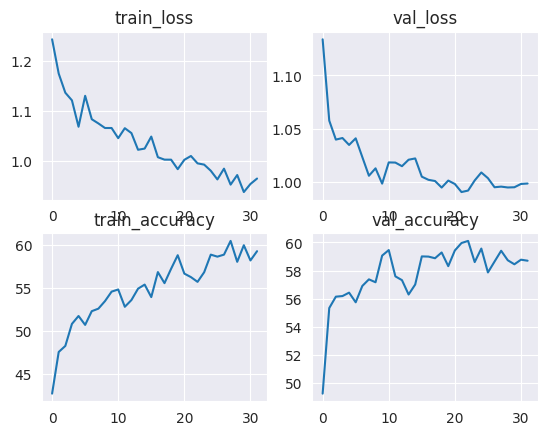

In [10]:
ff_model = FeedForwardModel(3 * 256 * 24, NUM_CLASSES).to(DEVICE)
train_progress, val_progress = executor(DEVICE, ff_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=0.0001, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(10,  0.001))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

        1990       0.53      0.70      0.60        53
        2000       0.56      0.44      0.49        50
        2010       0.48      0.43      0.45        46
         old       0.84      0.80      0.82        51

    accuracy                           0.60       200
   macro avg       0.60      0.59      0.59       200
weighted avg       0.60      0.60      0.60       200



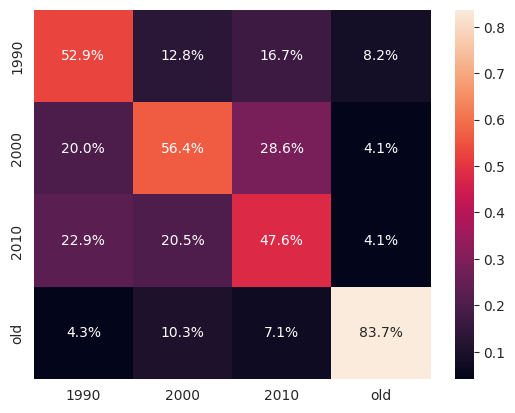

In [11]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, ff_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)

## Свертка по времени

In [12]:
from torch import nn

# Свертка по времени
class Conv1Model(nn.Module):
    def __init__(self, num_class, time_size, feature_size = 128):
        super(Conv1Model, self).__init__()

        horizontal_size = int(time_size / 4)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(horizontal_size, 1))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(horizontal_size, 1))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(horizontal_size, 1))
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(horizontal_size, 1))

        self.linear_1 = nn.Linear(4 * 128 * feature_size, 512)
        self.linear_2 = nn.Linear(512, 256)
        self.linear_3 = nn.Linear(256, 128)
        self.linear_4 = nn.Linear(128, 64)

        self.linear_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()

        self.conv_batchnorm1 = nn.BatchNorm2d(16)
        self.conv_batchnorm2 = nn.BatchNorm2d(32)
        self.conv_batchnorm3 = nn.BatchNorm2d(64)
        self.conv_batchnorm4 = nn.BatchNorm2d(128)

        self.linear_batchnorm1 = nn.BatchNorm1d(512)
        self.linear_batchnorm2 = nn.BatchNorm1d(256)
        self.linear_batchnorm3 = nn.BatchNorm1d(128)
        self.linear_batchnorm4 = nn.BatchNorm1d(64)


        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv_batchnorm1(x)
        x = self.relu(x)


        x = self.conv2(x)
        x = self.conv_batchnorm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.conv_batchnorm3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.conv_batchnorm4(x)
        x = self.relu(x)

        x = x.flatten(start_dim = 1)

        x = self.linear_1(x)
        x = self.linear_batchnorm1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.linear_2(x)
        x = self.linear_batchnorm2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.linear_3(x)
        x = self.linear_batchnorm3(x)
        x = self.relu(x)
        x = self.dropout3(x)

        x = self.linear_4(x)
        x = self.linear_batchnorm4(x)
        x = self.relu(x)
        x = self.dropout4(x)

        return self.linear_out(x)



 18%|█▊        | 18/100 [00:21<01:36,  1.18s/it]

Early stop!


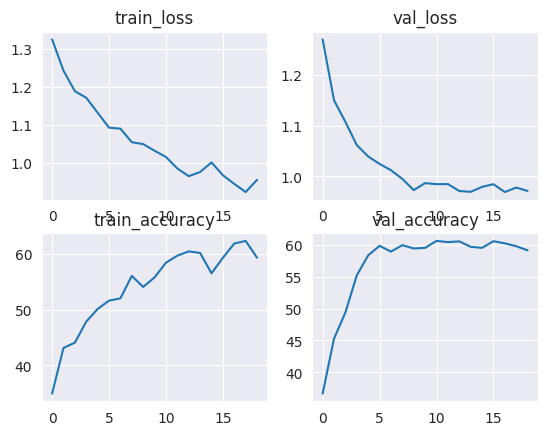

In [13]:
conv_1_model = Conv1Model(NUM_CLASSES, time_size=256, feature_size=24).to(DEVICE)
train_progress, val_progress = executor(DEVICE, conv_1_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=0.0001, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(10,  0.01))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

        1990       0.64      0.58      0.61        50
        2000       0.51      0.40      0.45        50
        2010       0.52      0.68      0.59        47
         old       0.81      0.83      0.82        53

    accuracy                           0.62       200
   macro avg       0.62      0.62      0.62       200
weighted avg       0.63      0.62      0.62       200



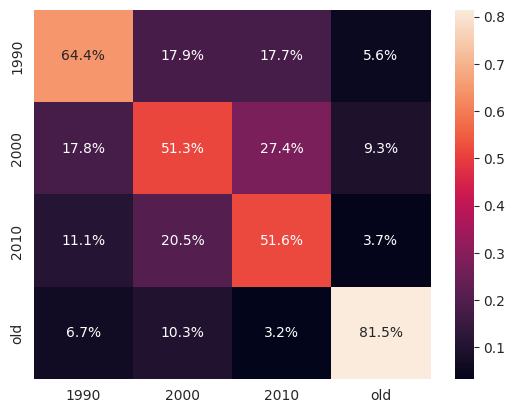

In [14]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, conv_1_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)